<a href="https://colab.research.google.com/github/OliviaA22/python/blob/main/Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing and Starting up a pyspark Session**

In [1]:
!pip install pyspark

In [2]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('InterviewExercise').getOrCreate()


**Importing the necessary libraries**

In [81]:

from pyspark.sql.functions import to_date, current_date, col, sum
from pyspark.sql.functions import when, isnull, regexp_replace, avg

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Loading the datasets:**

Pyspark does not read directly from xlsx file, therefore, the `customer_data` file format was converted from xlsx to csv before loading it.

The trasaction dataset was originall a csv file so i left as is.

In [5]:

excel_file = pd.ExcelFile('customer_data.xlsx')
df_merchants = excel_file.parse('master_data')
df_products = excel_file.parse('Sheet 2')
df_merchants.to_csv('customers.csv', index=False)
df_products.to_csv('products.csv', index=False)


In [6]:
customer_data = spark.read.csv('customers.csv', header=True, inferSchema=True)
product_data = spark.read.csv('products.csv', header=True, inferSchema=True)

transactions = spark.read.csv('trx_data.csv', header=True, inferSchema=True)


**Processing and Cleaning the Dataset:**

The `enddate` attribute was out of range, hence the reason for replacing it with the last date range in Python (`2262`).

It could be left it as it is but in order to be compatible and work pandas, it has to be replaced so that it will not be flagged as `NaT`.


**Note:** This would not have been a problem in R as `31.12.9999` is recognized as a date.

In [7]:
product_data = product_data.withColumn(
    'enddate',
    regexp_replace('enddate', '9998|9999', '2261')
)

In [10]:
product_data = product_data.withColumn('enddate', to_date('enddate'))

In [12]:
today = current_date()


Two observations were missing the `industry` attribute. Thus, In the cell below, I went ahead to replace it with the string `Unknown` instead of dropping the rows completely.

In [57]:
customer_data = customer_data.withColumn(
    'industry',
    when(col('industry').isNull(), 'Unknown').otherwise(col('industry'))
)

**Question 1:** How many customers have at least one active product?

In [13]:
active_products = product_data.filter(
    (col('enddate') > today)
)

In [45]:
active_customers = active_products.select('id_merchant').distinct()
print(f"Customers with at least one active product: {active_customers.count()}")

Customers with at least one active product: 701


**Question 2:** How many customers have one active products vs. those with two active products?

In [15]:
product_counts = active_products.groupBy('id_merchant').count()

customer_with_one_product = product_counts.filter(col('count') == 1).count()
customer_with_two_products = product_counts.filter(col('count') == 2).count()


print(f"Customers with 1 active product: {customer_with_one_product}")
print(f"Customers with 2 active products: {customer_with_two_products}")


Customers with 1 active product: 623
Customers with 2 active products: 78


<ipython-input-80-41a174e30d99>:8: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(


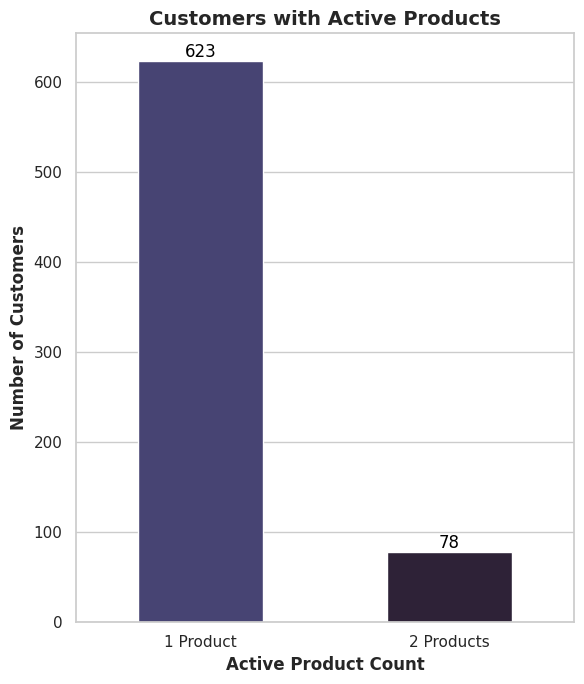

In [80]:
product_counts_pd = pd.DataFrame({
    'Active Products': ['1 Product', '2 Products'],
    'Number of Customers': [customer_with_one_product, customer_with_two_products]
})

sns.set(style="whitegrid")
plt.figure(figsize=(6, 7))
ax = sns.barplot(
    x='Active Products',
    y='Number of Customers',
    hue='Number of Customers',
    data=product_counts_pd,
    palette=sns.color_palette('mako'),
    width=0.5,
    legend=False
)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', color='black'
    )

plt.title('Customers with Active Products', fontsize=14, weight='bold')
plt.ylabel('Number of Customers', weight='bold')
plt.xlabel('Active Product Count', weight='bold')
plt.tight_layout()
plt.show()

**Question 3: What is the average transaction amount per industry?**

This was achieved by joining the transactions dataset to the customer dataset via merchant/customer IDs which I assumed to be the `id_m` and `merchant` attributes/variables, then grouping them by industry:

In [62]:
average_transaction = (
    transactions
    .join(customer_data, transactions.merchant == customer_data.id_m)
    .groupBy('industry')
    .agg(avg('trx_amount').alias('avg_trx_amount'))
    .orderBy('avg_trx_amount', ascending=False)
)

In [18]:

# average_transaction = average_transaction.withColumn(
#     'industry',
#     when(col('industry').isNull(), 'Unknown').otherwise(col('industry'))
# )

Converting the dataset from pyspark object to pandas to enable plot visualization in seaborn

In [63]:
average_transaction_pd = average_transaction.toPandas()

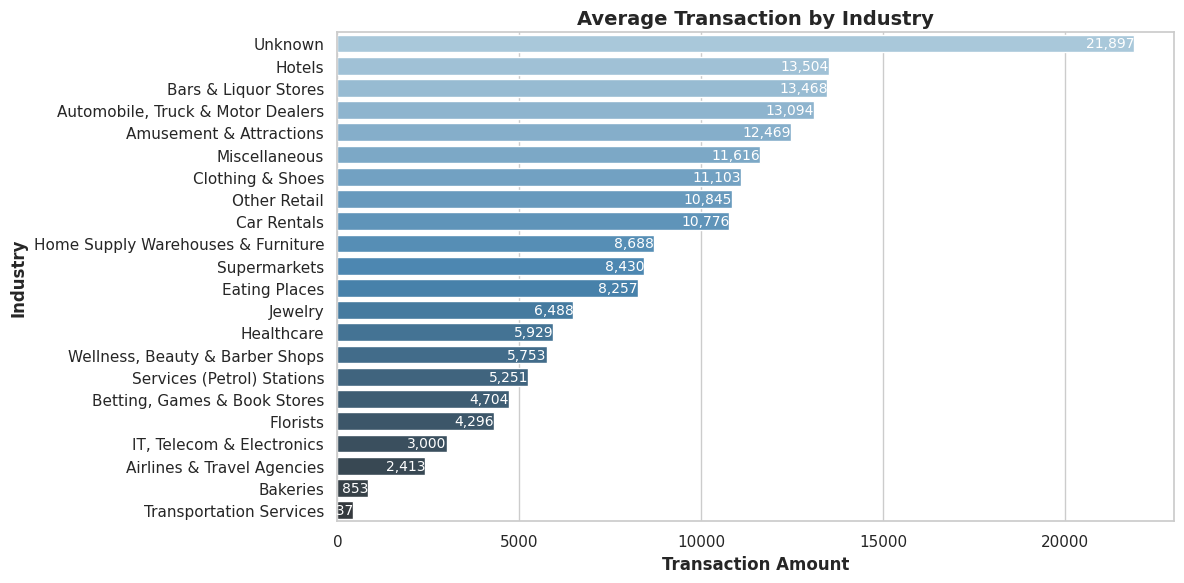

In [64]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='avg_trx_amount',
    y='industry',
    hue='industry',
    data=average_transaction_pd,
    palette='Blues_d',
    legend=False
)

plt.title('Average Transaction by Industry', fontsize=14, weight='bold')
plt.xlabel('Transaction Amount', weight='bold')
plt.ylabel('Industry', weight='bold')
plt.tight_layout()

# Adding the values to each bar for clarity
for i, (value, industry) in enumerate(zip(average_transaction_pd['avg_trx_amount'], average_transaction_pd['industry'])):
    ax.text(
        value,
        i,
        f'{value:,.0f}',
        va='center',
        ha='right',
        color='white',
        fontsize=10
    )

plt.show()

**Question 4**: Visualize the transactions and describe what you are seeing.



In [46]:
trx_pd = transactions.groupBy('trx_year', 'trx_month').sum('trx_amount').toPandas()
trx_pd['date'] = pd.to_datetime(trx_pd['trx_year'].astype(str) + '-' + trx_pd['trx_month'].astype(str) + '-01')
trx_pd = trx_pd.sort_values('date')
trx_pd['rolling_avg'] = trx_pd['sum(trx_amount)'].rolling(window=3, min_periods=1).mean()


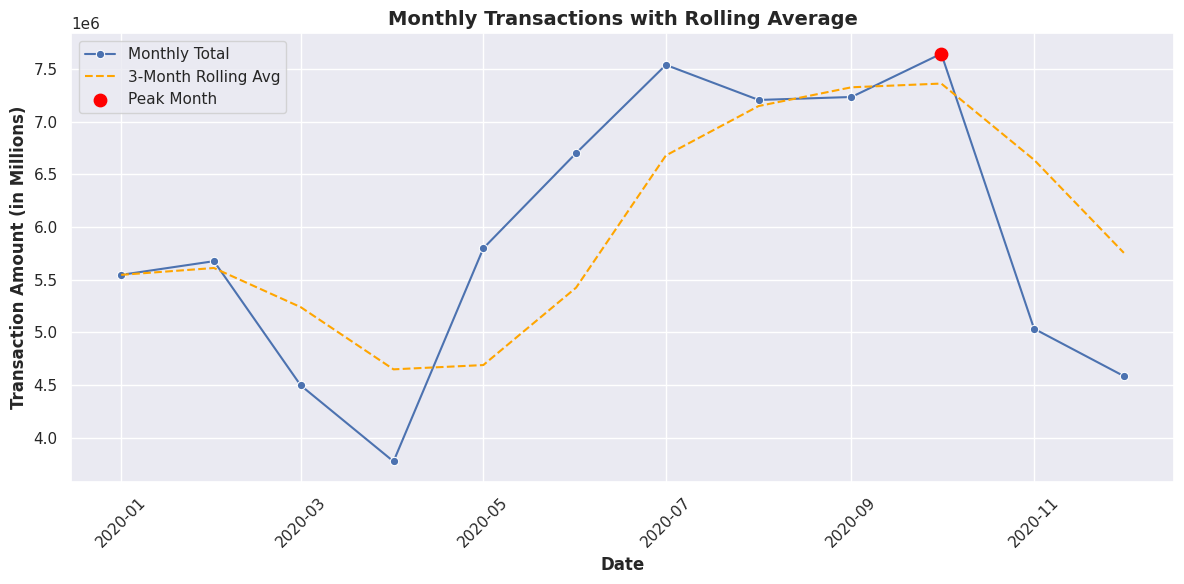

In [47]:

sns.set(style="darkgrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=trx_pd, x='date', y='sum(trx_amount)', marker='o', label='Monthly Total')
sns.lineplot(data=trx_pd, x='date', y='rolling_avg', label='3-Month Rolling Avg',color='orange',  linestyle='--')

peak = trx_pd.loc[trx_pd['sum(trx_amount)'].idxmax()]
plt.scatter(peak['date'], peak['sum(trx_amount)'], color='red', s=80, label='Peak Month', zorder=5)


plt.title('Monthly Transactions with Rolling Average', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12, weight='bold')
plt.ylabel('Transaction Amount (in Millions)', fontsize=12, weight='bold')
plt.xticks(rotation=45)
plt.legend()


plt.tight_layout()
plt.show()


**Key insights:**

- There is a strong seasonal trend pattern as can be clearly observed by the rise in transaction volume from May with a significanant peaking in October (Probably Black Friday Sales).

- The early part of the year can be described as volatile with significantly lower transaction amounts, which then took an uopward turn with a sharp increase.

- After reaching the peak in October, the transaction amounts once again dropped sharply in November and December.

- The rolling average plot with a 3-month window was used to smoothen out the noise and show a slightly curvy slope.

**Business Implication:**

This pattern could be due to industry seasonality, marketing campaigns, or external factors affecting customer behavior. Without much background information about the datasets, It is slight difficult to investigate what drives the peak as well as the reason for the sudden steepy decline afterwards..



---
---


**Optional Visualization Ideas:**

- Get the number of inactive customers - **Customer churn**
- **Top industries by their transaction volume**: Which industries have the largest customer bases?
- Total transaction volume per customer.
- **Most Popular Products**: Which products have the highest number of active customers?
- **Active vs. Inactive by Industry:** What is the ratio of active to inactive customers across industries?

In [23]:
inactive_products = product_data.filter(
    (col('enddate') < today)
)

In [55]:
print(f"inactive products: {inactive_products.count()}")
print(f"active products: {active_products.count()}")
print(f"Customers with at least one active product: {active_customers.count()}")

inactive products: 677
active products: 779
Customers with at least one active product: 701


In [61]:
all_customers = customer_data.select('id_m').distinct()


inactive_customers = all_customers.join(
    active_customers,
    all_customers.id_m == active_customers.id_merchant,
    how='left_anti'
)


number_of_active_customers = active_customers.count()
number_of_inactive_customers = inactive_customers.count()

In [53]:
customer_comparison_pd = pd.DataFrame({
    'Customers': ['Active', 'Inactive'],
    'Number of Customers': [number_of_active_customers, number_of_inactive_customers]
})

<ipython-input-77-b89754725eb9>:2: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.barplot(


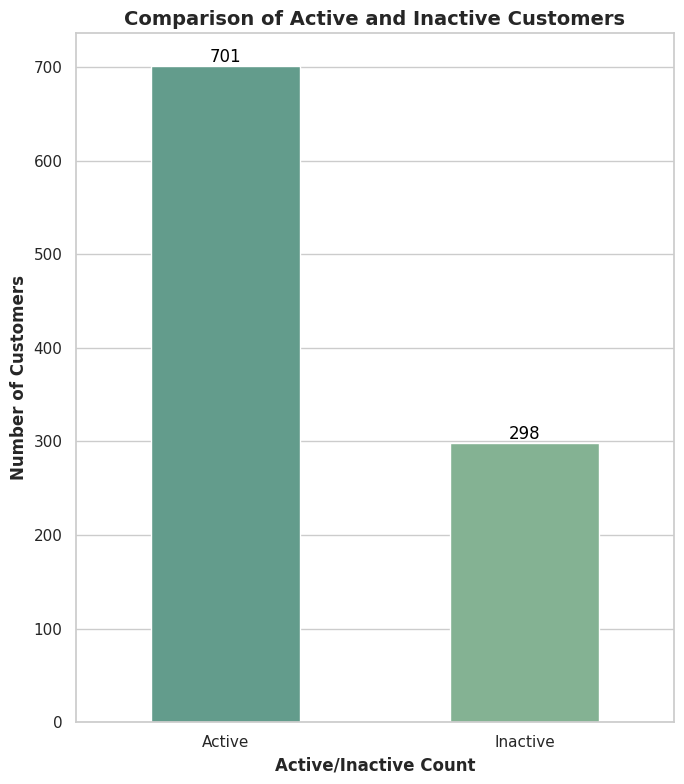

In [77]:

plt.figure(figsize=(7, 8))
ax = sns.barplot(
    x='Customers',
    y='Number of Customers',
    hue='Number of Customers',
    data=customer_comparison_pd,
    palette=sns.color_palette('crest'),
    width=0.5,
    legend=False
)

# Add value labels
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', color='black'
    )

plt.title('Comparison of Active and Inactive Customers', fontsize=14, weight='bold')
plt.ylabel('Number of Customers', weight='bold')
plt.xlabel('Active/Inactive Count', weight='bold')
plt.tight_layout()
plt.show()


In [71]:
industry_customers = (
    customer_data
    .groupBy('industry')
    .count()
    .orderBy('count', ascending=False)
)
industry_customers.show(25)

+--------------------+-----+
|            industry|count|
+--------------------+-----+
|        Other Retail|  177|
|       Eating Places|  120|
|    Clothing & Shoes|  108|
|          Healthcare|   91|
|Automobile, Truck...|   69|
|              Hotels|   69|
|Wellness, Beauty ...|   56|
|       Miscellaneous|   49|
|             Jewelry|   42|
|Home Supply Wareh...|   40|
|        Supermarkets|   27|
|Transportation Se...|   23|
|IT, Telecom & Ele...|   21|
|            Florists|   21|
|Betting, Games & ...|   19|
|Airlines & Travel...|   19|
|Amusement & Attra...|   15|
|Bars & Liquor Stores|   15|
|Services (Petrol)...|    8|
|         Car Rentals|    5|
|            Bakeries|    3|
|             Unknown|    2|
+--------------------+-----+



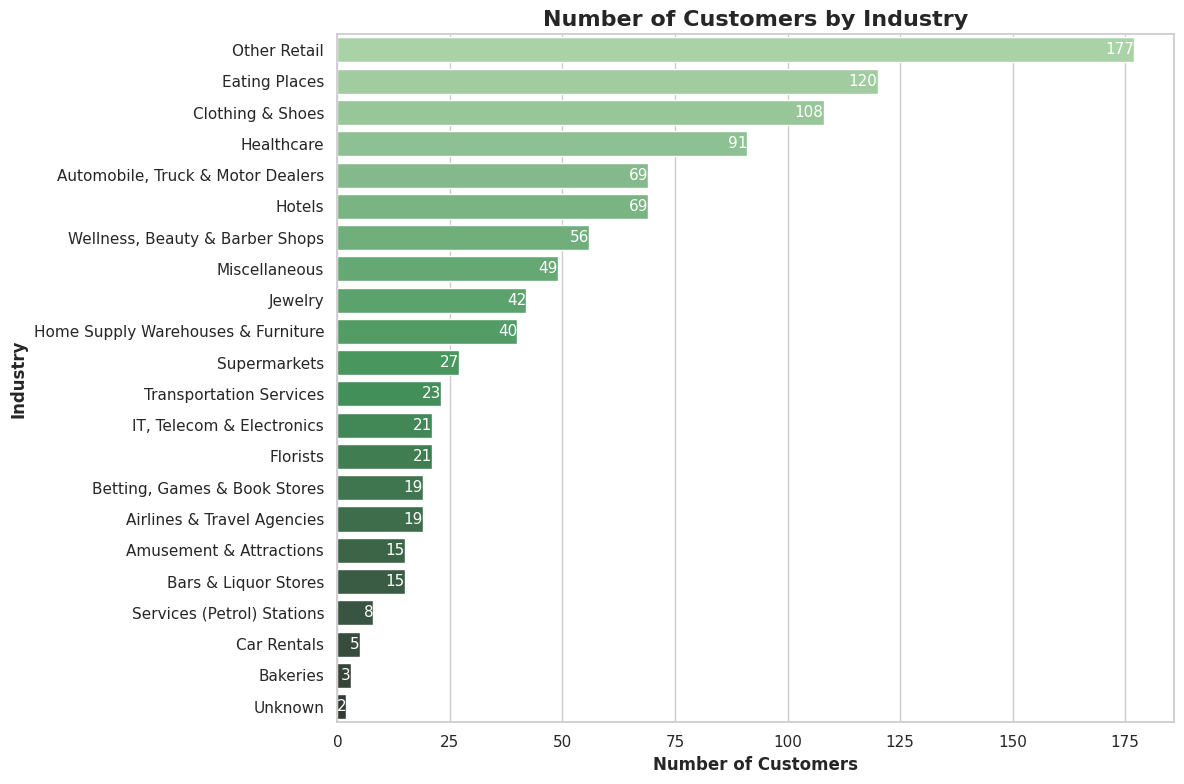

In [84]:
industry_customers_pd = industry_customers.toPandas()

industry_customers_pd = industry_customers_pd.sort_values('count', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='count',
    y='industry',
    hue='industry',
    data=industry_customers_pd,
    palette='Greens_d'
)

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_width())}',
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='right', va='center', fontsize=11, color='white'
    )

plt.title('Number of Customers by Industry', fontsize=16, weight='bold')
plt.xlabel('Number of Customers', weight='bold')
plt.ylabel('Industry', weight='bold')
plt.tight_layout()
plt.show()

In [105]:
# Example join in PySpark
joined_df = transactions.join(
    customer_data,
    transactions.merchant == customer_data.id_m,
    how='left'
)

customer_transaction = joined_df.select(
    transactions['*'],
    customer_data['name_mcc_eng']
)


In [106]:
customer_volume = (
    customer_transaction
    .groupBy('merchant', 'name_mcc_eng')
    .agg(sum('trx_amount').alias('total_trx_amount'))
    .orderBy('total_trx_amount', ascending=False)
)
customer_volume.show()


+--------+--------------------+------------------+
|merchant|        name_mcc_eng|  total_trx_amount|
+--------+--------------------+------------------+
| 3885179|Automobile & Truc...|        1785526.69|
| 3821315|Miscellaneous & S...|1744463.0499999998|
| 3765453|Men’s & Women’s C...|        1588674.04|
| 3878845|Business Services...|1575341.3599999999|
| 3754246|Miscellaneous & S...|1232558.3499999999|
| 3851707|Package Stores - ...|        1011185.13|
| 3818027|Lodging - Hotels,...| 994948.3200000001|
| 3891983|Lumber & Building...| 830183.9899999999|
| 3733295|Children’s & Infa...|          808237.3|
| 3848811|Eating Places & R...|         808181.89|
| 3603925|Lodging - Hotels,...|         796800.08|
| 3844139|Miscellaneous & S...|         775338.05|
| 3802985| Veterinary Services|         653050.99|
| 3727557|Jewelry Stores, W...| 645869.9600000001|
| 3823993|Miscellaneous & S...| 643505.5000000001|
| 3589874|Lodging - Hotels,...| 629146.8700000001|
| 3841590|Amusement Recreat...|

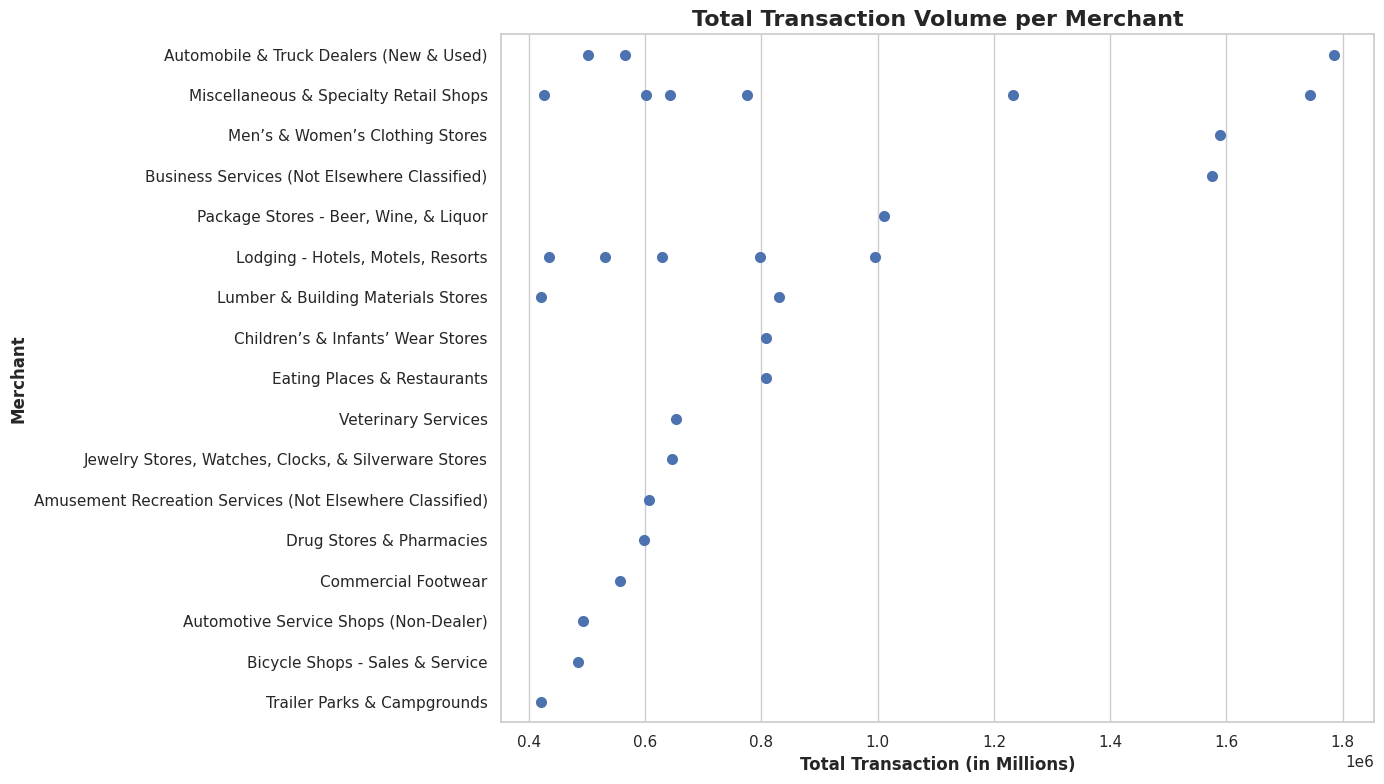

In [104]:
customer_volume_pd = customer_volume.toPandas()

top_n = 30
top_merchants = customer_volume_pd.nlargest(top_n, 'total_trx_amount')


plt.figure(figsize=(14, 8))

# Dot plot (strip plot) with one dot per merchant
sns.stripplot(
    x='total_trx_amount',
    y='name_mcc_eng',
    data=top_merchants,
    size=8,
    orient='h',
    color='b',
    jitter=False
)

plt.title('Total Transaction Volume per Merchant', fontsize=16, weight='bold')
plt.xlabel('Total Transaction (in Millions)', weight='bold')
plt.ylabel('Merchant', weight='bold')
plt.tight_layout()
plt.show()